In [32]:
library(tidyverse)
library(Hmisc) #capitalize
library(reshape)

library(ggplot2)
library(ggpubr) #plot
library(rstatix) #easy statistical analyses

library(car)
library(effsize)

# Import data

In [33]:
# pca data
USA_pca = read.csv('../output_data/pca_results/USA/USA_scores_var_33d.csv',
                   row.names=1)
colnames(USA_pca) = c('Formality','Activeness','Valence','Exchange','Equality')
USA_pca['Equality'] = -USA_pca['Equality']

CHN_pca = read.csv('../output_data/pca_results/CHN/CHN_NLP_159rel_33d_scores_var.csv',
                   row.names=1)
colnames(CHN_pca) = c('Valence','Exchange','Equality','Formality','Activeness')
CHN_pca['Equality'] = -CHN_pca['Equality']

In [34]:
# select Power cluster from results of 6 clusters in Study2(explicit category task)
Occupational = c('Student and Dorm Resident assistant','Union leader and union member','Intern and Employee',
'Mentor and Mentee','Religious leader and Congregant','Teacher and Student','Employer and Employee',
'Supervisor and Subordinate','Team Captain and Team Members','Predecessor and Successor',
'Interviewer and Job applicant','Officer and Soldier','Between a monarch and their minister',
'Professor and Graduate student','Director and Performer','Athletic trainer and Trainee',
'Doctor and Nurse','Landlord and Housekeeper','Foreman and Laborer','Superior and Subordinate',
'Club Member and Club President','Chief and Deputy','Athlete and Referee','Principal and Teacher',
'Judge and Lawyer','Coach and athlete','University student and Administrator','Leader and Follower',
'Man and God','Volunteer and Organizer','Manager and Staff','Owner and Manager','Manager and Assistant',
'Boss and Secretary','Professor and Teaching Assistant')#,'Judge and Contestant')
length(Occupational)

# Relationships with differences in seniority(beifen) in family
Familial = c('Parent and Child','Parent and Teenager','Parent and Infant',
 'Grandparent and Grandchild','Step-parent and Step-child','Foster-parent and Foster-child',
 'Godparent and Godchild','Step-grandparent and Step-grandchild','Ancestor and Descendant',
             'Between a person and their in-laws',
 'Aunt and Niece/Nephew','Uncle and Niece/Nephew','Between adoptive parents and adopted kids',
 'Mother and Infant')
 length(Familial)

[1] 35

[1] 14

In [35]:
write.csv(Occupational,'selected_rels/Occupational.csv')
write.csv(Familial,'selected_rels/Familial.csv')

# ANOVA: PCA

## direct computation

In [36]:
USA_equ_pca = USA_pca %>% filter(rownames(USA_pca) %in% c(Occupational,Familial)) %>% 
    select('Equality')
CHN_equ_pca = CHN_pca %>% filter(rownames(CHN_pca) %in% c(Occupational,Familial)) %>% 
    select('Equality')

USA_CHN_equ_pca = cbind(USA_equ_pca,CHN_equ_pca)
colnames(USA_CHN_equ_pca) = c('USA','CHN')
USA_CHN_equ_pca$'rel' = rownames(USA_CHN_equ_pca)
USA_CHN_equ_pca = USA_CHN_equ_pca %>% mutate(cluster = case_when(
                                    rel %in% Occupational~'Occupational',
                                    rel %in% Familial~'Familial'))

USA_CHN_equ_pca_melt = melt(USA_CHN_equ_pca,id.vars=c('rel','cluster'))
colnames(USA_CHN_equ_pca_melt) = c('rel','cluster','region','score')
USA_CHN_equ_pca_melt$index = rownames(USA_CHN_equ_pca_melt)

USA_CHN_equ_pca_melt$region = factor(USA_CHN_equ_pca_melt$region,levels = c('CHN','USA'))

,Effect,DFn,DFd,F,p,p<.05,pes
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,cluster,1,94,63.293,3.95e-12,*,0.402
2,region,1,94,17.300,7.05e-05,*,0.155
3,cluster:region,1,94,9.795,2.00e-03,*,0.094


cluster      .y.   group1 group2 n1 n2 p        p.signif p.adj   
1 Familial     score CHN    USA    14 14 6.02e-05 ****     6.02e-05
2 Occupational score CHN    USA    35 35 3.55e-01 ns       3.55e-01
  p.adj.signif y.position groups <NA> x xmin xmax
1 ****         -0.00728   CHN    CHN  1 0.8  1.2 
2 ns            0.71472   USA    USA  2 1.8  2.2

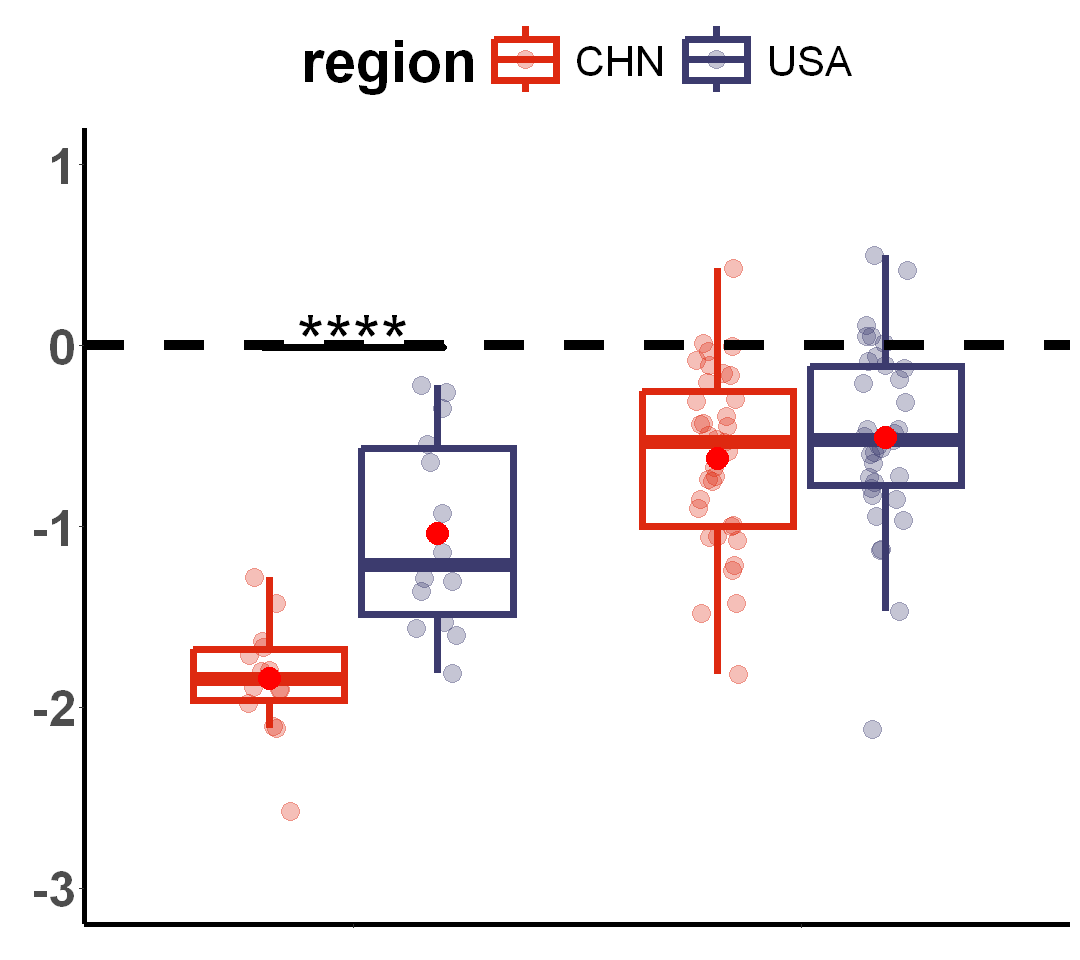

In [37]:
# Anova
# res.aov = USA_CHN_equ_pca_melt %>% anova_test(score~region*cluster)
# res.aov
res.aov = anova_test(
    data = USA_CHN_equ_pca_melt,dv = score, wid = index,
    between = c(cluster,region), effect.size = "pes")
get_anova_table(res.aov)


# Post hoc2
pwc <- USA_CHN_equ_pca_melt %>%
  group_by(cluster) %>%
  pairwise_t_test(score ~ region, p.adjust.method = "bonferroni",paired=FALSE) #%>%
  #select(-p, -p.signif) # Remove details
pwc <- pwc %>% add_xy_position(x = "cluster")
pwc

# Visualization
my_color = c('USA'='#3C3B6E','CHN'='#DE2910')
options(repr.plot.width = 9,repr.plot.height = 8)
ggplot(USA_CHN_equ_pca_melt)+
geom_boxplot(aes(x=cluster,y=score,color=region),
             outlier.alpha = 0,size=2)+
geom_point(aes(x=cluster,y=score,color=region),position = position_jitterdodge(0.2),size=5,alpha=0.3)+
stat_summary(aes(x=cluster,y=score,group=region),position=position_dodge(0.75),
             fun='mean',color='red',size=6,geom='point')+
scale_color_manual(values=my_color)+
geom_hline(yintercept = 0,linetype='dashed',size = 3)+

stat_pvalue_manual(pwc, tip.length = 0, hide.ns = TRUE,size = 15,bracket.size = 2)+

theme_classic()+
theme(#axis.text.x = element_text(size=36,face='bold'),
      axis.text.x = element_blank(),
      axis.text.y = element_text(size=30,face='bold'),
      legend.key.size = unit(50,'pt'),
      legend.title = element_text(size=35,face='bold'),
      legend.text = element_text(size=25),
      legend.position = 'top',
      axis.line = element_line(linetype=1,color="black",size=1.5))+
xlab('')+
ylab('')+
ylim(-3,1)

In [38]:
head(USA_CHN_equ_pca_melt)

,rel,cluster,region,score,index
,<chr>,<chr>,<fct>,<dbl>,<chr>
1,Parent and Child,Familial,USA,-1.36084882,1
2,Parent and Teenager,Familial,USA,-0.34852507,2
3,Between a person and their in-laws,Familial,USA,-0.22082527,3
4,Employer and Employee,Occupational,USA,-0.52567904,4
5,Interviewer and Job applicant,Occupational,USA,0.01328282,5
6,Teacher and Student,Occupational,USA,-0.85051347,6


In [39]:
usa_familial = USA_CHN_equ_pca_melt %>% filter(cluster == 'Familial') %>% filter(region == 'USA')
chn_familial = USA_CHN_equ_pca_melt %>% filter(cluster == 'Familial') %>% filter(region == 'CHN')

levene = leveneTest(score~region, USA_CHN_equ_pca_melt %>% filter(cluster == 'Familial'))
print(levene)
t.test(chn_familial$'score', usa_familial$'score', paired = FALSE, var.equal = FALSE)
cohen.d(chn_familial$'score', usa_familial$'score')

Levene's Test for Homogeneity of Variance (center = median)
      Df F value  Pr(>F)  
group  1  4.8495 0.03672 *
      26                  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



	Welch Two Sample t-test

data:  chn_familial$score and usa_familial$score
t = -4.7791, df = 20.852, p-value = 0.000103
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -1.151899 -0.453156
sample estimates:
mean of x mean of y 
-1.842023 -1.039496 



Cohen's d

d estimate: -1.806319 (large)
95 percent confidence interval:
     lower      upper 
-2.7281528 -0.8844851 


In [40]:
usa_occupational = USA_CHN_equ_pca_melt %>% filter(cluster == 'Occupational') %>% filter(region == 'USA')
chn_occupational = USA_CHN_equ_pca_melt %>% filter(cluster == 'Occupational') %>% filter(region == 'CHN')

levene = leveneTest(score~region, USA_CHN_equ_pca_melt %>% filter(cluster == 'Occupational'))
print(levene)
t.test(chn_occupational$'score', usa_occupational$'score', paired = FALSE, var.equal = TRUE)
cohen.d(chn_occupational$'score', usa_occupational$'score')

Levene's Test for Homogeneity of Variance (center = median)
      Df F value Pr(>F)
group  1  0.0226 0.8811
      68               



	Two Sample t-test

data:  chn_occupational$score and usa_occupational$score
t = -0.93068, df = 68, p-value = 0.3553
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.3564458  0.1297063
sample estimates:
 mean of x  mean of y 
-0.6215078 -0.5081380 



Cohen's d

d estimate: -0.2224749 (small)
95 percent confidence interval:
     lower      upper 
-0.7009566  0.2560067 


In [41]:
# Visualization
png("../../output_graph/USA_CHN/Equality.png", bg="transparent",
    family = 'sans',units='in',width=10,height=10,res=300)
my_color = c('USA'='#3C3B6E','CHN'='#DE2910')
options(repr.plot.width = 7,repr.plot.height = 7)
ggplot(USA_CHN_equ_pca_melt)+
geom_boxplot(aes(x=cluster,y=score,color=region),
             outlier.alpha = 0,size=2)+
geom_point(aes(x=cluster,y=score,color=region),position = position_jitterdodge(0.2),size=5,alpha=0.3)+
stat_summary(aes(x=cluster,y=score,group=region),position=position_dodge(0.75),
             fun='mean',color='red',size=6,geom='point')+
scale_color_manual(values=my_color)+
geom_hline(yintercept = 0,linetype='dashed',size = 3)+

#stat_pvalue_manual(pwc, tip.length = 0, hide.ns = TRUE,size = 15,bracket.size = 2)+

theme_classic()+
theme(#axis.text.x = element_text(size=36,face='bold'),
      axis.text.x = element_blank(),
      #axis.text.y = element_text(size=30,face='bold'),
      axis.text.y = element_blank(),
      legend.key.size = unit(50,'pt'),
      legend.title = element_text(size=35,face='bold'),
      legend.text = element_text(size=25),
      legend.position = 'top',
      axis.line = element_line(linetype=1,color="black",size=1.5))+
xlab('')+
ylab('')+
ylim(-3,1)
dev.off()

png 
  2

## outlier

### first time

In [42]:
USA_CHN_equ_pca_melt %>% group_by(cluster,region) %>% identify_outliers(score)

cluster,region,rel,score,index,is.outlier,is.extreme
<chr>,<fct>,<chr>,<dbl>,<chr>,<lgl>,<lgl>
Familial,CHN,Ancestor and Descendant,-2.573347,63,TRUE,FALSE
Occupational,USA,Man and God,-2.120244,34,TRUE,FALSE


cluster,region,rel,score,index,is.outlier,is.extreme
<chr>,<fct>,<chr>,<dbl>,<chr>,<lgl>,<lgl>
Familial,CHN,Between a person and their in-laws,-1.279681,52,TRUE,FALSE


,Effect,DFn,DFd,F,p,p<.05,ges
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,cluster,1,45,48.992,1.02e-08,*,0.444
2,region,1,45,37.477,2.06e-07,*,0.182
3,cluster:region,1,45,19.721,5.76e-05,*,0.105


cluster,Effect,DFn,DFd,F,p,p<.05,ges,p.adj
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
Familial,region,1,12,31.673,0.000111,*,0.490,0.000222
Occupational,region,1,33,2.773,0.105000,,0.019,0.210000


cluster      .y.   group1 group2 n1 n2 p        p.signif p.adj   
1 Familial     score CHN    USA    13 13 6.88e-05 ****     6.88e-05
2 Occupational score CHN    USA    34 34 2.56e-01 ns       2.56e-01
  p.adj.signif y.position groups <NA> x xmin xmax
1 ****         -0.00728   CHN    CHN  1 0.8  1.2 
2 ns            0.71472   USA    USA  2 1.8  2.2

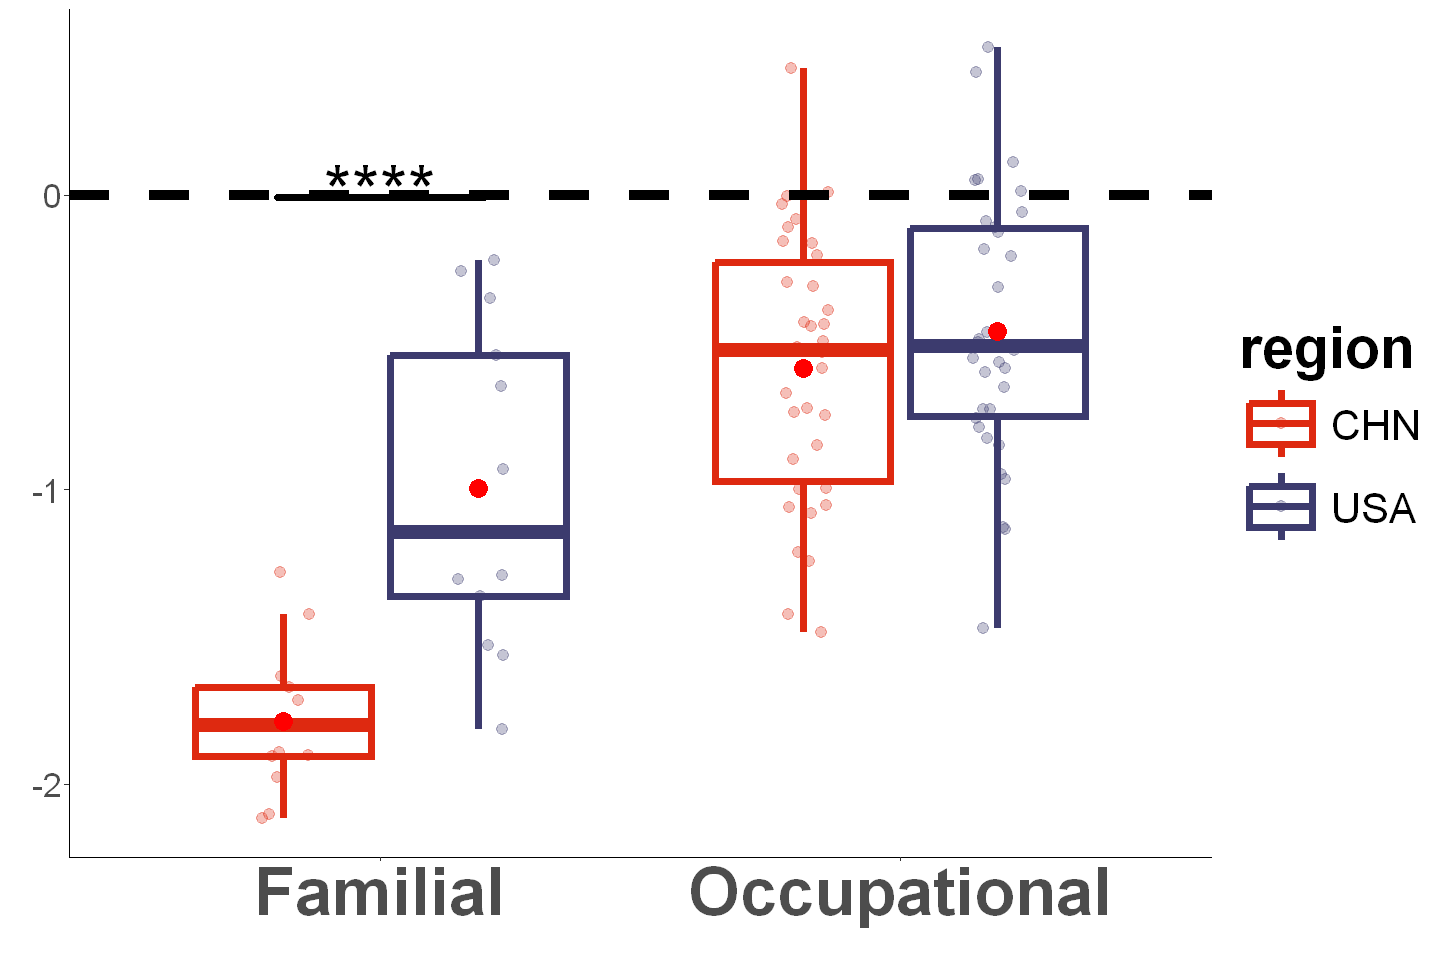

In [43]:
outlier = c('Ancestor and Descendant','Man and God')
USA_CHN_equ_pca_melt_nooutliers = USA_CHN_equ_pca_melt[-which(USA_CHN_equ_pca_melt$rel%in%outlier),]
USA_CHN_equ_pca_melt_nooutliers %>% group_by(cluster,region) %>% identify_outliers(score)

# Anova
res.aov = anova_test(
    data = USA_CHN_equ_pca_melt_nooutliers,dv = score, wid = rel,
    between = cluster, within = region)
get_anova_table(res.aov)

# Post hoc1
one.way = USA_CHN_equ_pca_melt_nooutliers %>% group_by(cluster) %>%
    anova_test(dv = score, wid = rel, within = region) %>%
    get_anova_table() %>%
    adjust_pvalue(method = 'bonferroni')
one.way

# Post hoc2
pwc <- USA_CHN_equ_pca_melt_nooutliers %>%
  group_by(cluster) %>%
  pairwise_t_test(score ~ region, p.adjust.method = "bonferroni",paired = FALSE) #%>%
  #select(-p, -p.signif) # Remove details
pwc <- pwc %>% add_xy_position(x = "cluster")
pwc

# Visualization
my_color = c('USA'='#3C3B6E','CHN'='#DE2910')
options(repr.plot.width = 12,repr.plot.height = 8)
ggplot(USA_CHN_equ_pca_melt_nooutliers)+
geom_boxplot(aes(x=cluster,y=score,color=region),
             outlier.alpha = 0,size=2)+
geom_point(aes(x=cluster,y=score,color=region),position = position_jitterdodge(0.2),size=3,alpha=0.3)+
stat_summary(aes(x=cluster,y=score,group=region),position=position_dodge(0.75),
             fun='mean',color='red',size=5,geom='point')+
scale_color_manual(values=my_color)+
geom_hline(yintercept = 0,linetype='dashed',size = 3)+
# scale_x_discrete(labels = c("psy" = "psychological","phy" = "physical"))+

stat_pvalue_manual(pwc, tip.length = 0, hide.ns = TRUE,size = 15,bracket.size = 2)+

theme_classic()+
theme(axis.text.x = element_text(size=40,face='bold'),
      axis.text.y = element_text(size=20),
      legend.key.size = unit(50,'pt'),
      legend.title = element_text(size=35,face='bold'),
      legend.text = element_text(size=25))+
xlab('')+
ylab('')

### second time

cluster,region,rel,score,index,is.outlier,is.extreme
<chr>,<fct>,<chr>,<dbl>,<chr>,<lgl>,<lgl>


,Effect,DFn,DFd,F,p,p<.05,ges
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,cluster,1,43,66.703,2.75e-10,*,0.516
2,region,1,43,32.450,1.01e-06,*,0.191
3,cluster:region,1,43,16.444,2.07e-04,*,0.107


cluster,Effect,DFn,DFd,F,p,p<.05,ges,p.adj
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
Familial,region,1,11,25.963,0.000347,*,0.518,0.000694
Occupational,region,1,32,2.762,0.106000,,0.023,0.212000


cluster      .y.   group1 group2 n1 n2 p        p.signif p.adj   
1 Familial     score CHN    USA    12 12 0.000074 ****     0.000074
2 Occupational score CHN    USA    33 33 0.223000 ns       0.223000
  p.adj.signif y.position groups <NA> x xmin xmax
1 ****         -0.028     CHN    CHN  1 0.8  1.2 
2 ns            0.732     USA    USA  2 1.8  2.2

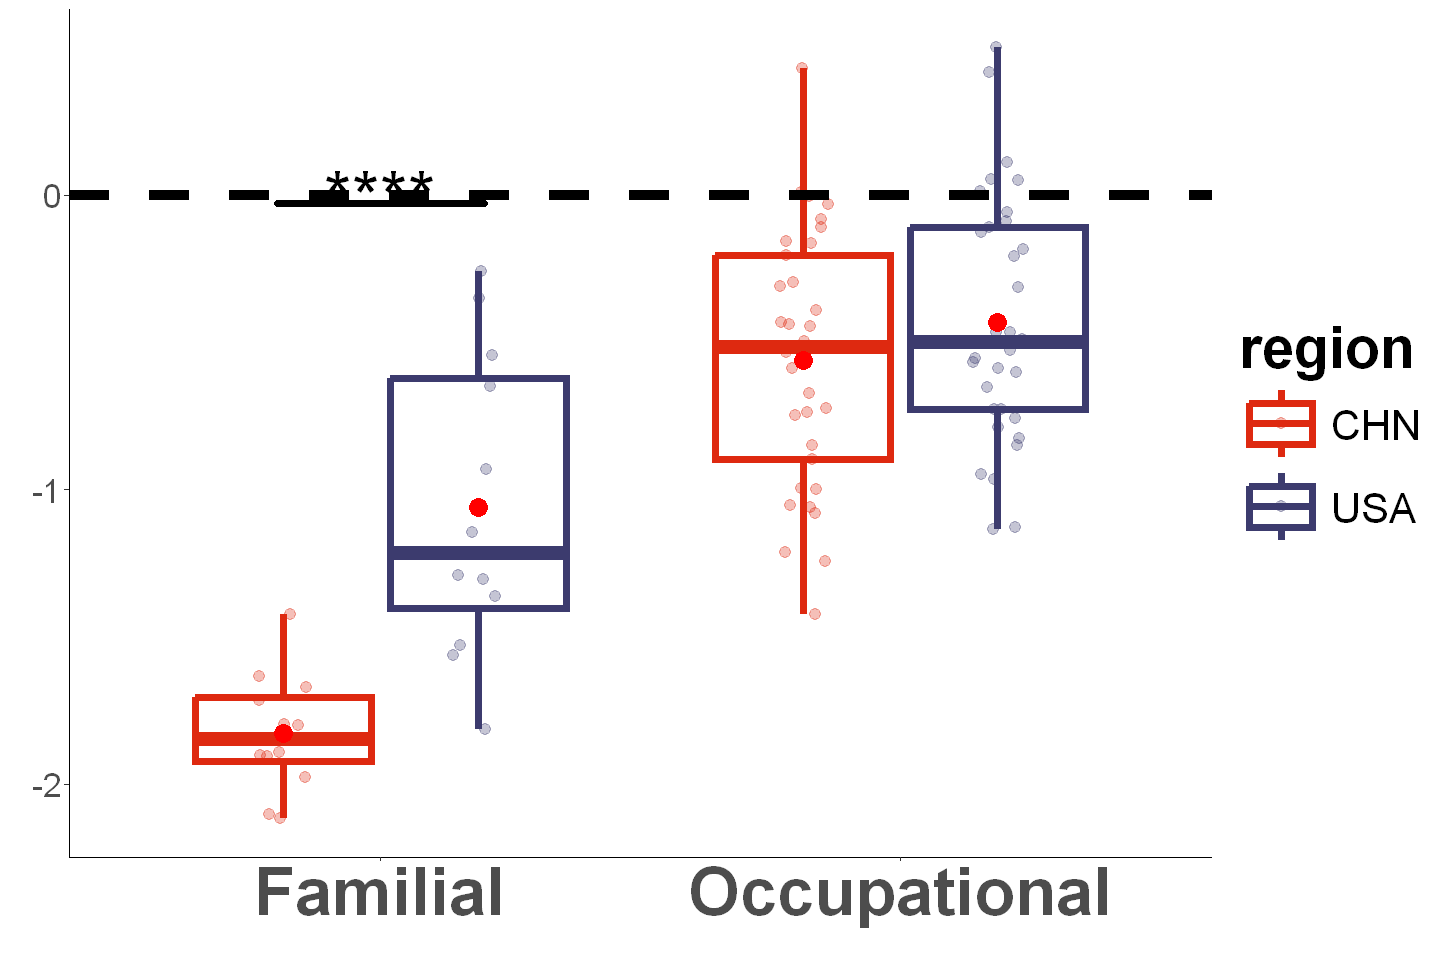

In [44]:
outlier = c('Ancestor and Descendant','Man and God','Officer and Soldier',
           'Between a person and their in-laws')
USA_CHN_equ_pca_melt_nooutliers = USA_CHN_equ_pca_melt[-which(USA_CHN_equ_pca_melt$rel%in%outlier),]
USA_CHN_equ_pca_melt_nooutliers %>% group_by(cluster,region) %>% identify_outliers(score)

# Anova
res.aov = anova_test(
    data = USA_CHN_equ_pca_melt_nooutliers,dv = score, wid = rel,
    between = cluster, within = region)
get_anova_table(res.aov)

# Post hoc1
one.way = USA_CHN_equ_pca_melt_nooutliers %>% group_by(cluster) %>%
    anova_test(dv = score, wid = rel, within = region) %>%
    get_anova_table() %>%
    adjust_pvalue(method = 'bonferroni')
one.way

# Post hoc2
pwc <- USA_CHN_equ_pca_melt_nooutliers %>%
  group_by(cluster) %>%
  pairwise_t_test(score ~ region, p.adjust.method = "bonferroni", paired = FALSE) #%>%
  #select(-p, -p.signif) # Remove details
pwc <- pwc %>% add_xy_position(x = "cluster")
pwc

# Visualization
my_color = c('USA'='#3C3B6E','CHN'='#DE2910')
options(repr.plot.width = 12)
ggplot(USA_CHN_equ_pca_melt_nooutliers)+
geom_boxplot(aes(x=cluster,y=score,color=region),
             outlier.alpha = 0,size=2)+
geom_point(aes(x=cluster,y=score,color=region),position = position_jitterdodge(0.2),size=3,alpha=0.3)+
stat_summary(aes(x=cluster,y=score,group=region),position=position_dodge(0.75),
             fun='mean',color='red',size=5,geom='point')+
scale_color_manual(values=my_color)+
geom_hline(yintercept = 0,linetype='dashed',size = 3)+
# scale_x_discrete(labels = c("psy" = "psychological","phy" = "physical"))+

stat_pvalue_manual(pwc, tip.length = 0, hide.ns = TRUE,size = 15,bracket.size = 2)+

theme_classic()+
theme(axis.text.x = element_text(size=40,face='bold'),
      axis.text.y = element_text(size=20),
      legend.key.size = unit(50,'pt'),
      legend.title = element_text(size=35,face='bold'),
      legend.text = element_text(size=25))+
xlab('')+
ylab('')